# Тематическая классификация длинных текстов - TFIDF и LogReg

In [1]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

!git clone https://github.com/chmnk/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
import sys; sys.path.append('./stepik-dl-nlp')

import os
print(os.listdir('.'))

Cloning into 'stepik-dl-nlp'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 322 (delta 30), reused 14 (delta 5), pack-reused 266
Receiving objects: 100% (322/322), 42.35 MiB | 20.85 MiB/s, done.
Resolving deltas: 100% (159/159), done.
     |████████████████████████████████| 61kB 3.3MB/s 
     |████████████████████████████████| 1.7MB 6.6MB/s 
     |████████████████████████████████| 24.2MB 42.9MB/s 
     |████████████████████████████████| 307kB 38.0MB/s 
     |████████████████████████████████| 8.2MB 32.4MB/s 
  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=83218b67bd3b58f8a1f94fdb4f1010021a636d4b67d0967b7051011dc70d857a
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
  Created wheel for ufal.udpipe: filename=ufal.udpipe-1.2.0.3-cp36-cp36m-linux_x86_64.whl size=5625171 sha256=098c5a7e13b6a8f25e2792

In [15]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import collections

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils
from dlnlputils.data import tokenize_text_simple_regex, tokenize_corpus, build_vocabulary, \
    vectorize_texts, SparseFeaturesDataset
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed

import re
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MaxAbsScaler
import scipy.sparse.linalg
from copy import deepcopy

import scipy.sparse
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


init_random_seed()

## Предобработка текстов и подготовка признаков

In [3]:
train_source = fetch_20newsgroups(subset='train')
test_source = fetch_20newsgroups(subset='test')

print('Количество обучающих текстов', len(train_source['data']))
print('Количество тестовых текстов', len(test_source['data']))
print()
print(train_source['data'][0].strip())

print()
print('Метка', train_source['target'][0])

Количество обучающих текстов 11314
Количество тестовых текстов 7532

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----

Метка 7


In [ ]:
print(train_source.keys(), type(train_source))
print(train_source['target_names'][7])
print(' '.join(train_source['data'][0].split('\n')[5:10]))

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR']) <class 'sklearn.utils.Bunch'>
rec.autos
  I was wondering if anyone out there could enlighten me on this car I saw the other day. It was a 2-door sports car, looked to be from the late 60s/ early 70s. It was called a Bricklin. The doors were really small. In addition, the front bumper was separate from the rest of the body. This is 


##Моя токенизация для мелких задач

In [ ]:
TOKEN_RE_wd = re.compile(r'[\w\d]+')
TOKEN_RE_mine = re.compile(r'[^\d\W]+|[\d]*\.[\d]+|-[\d]*\.[\d]+|-[\d]+|[\d]+|\.[\d]+|[^\s]')


def tokenize_text_simple_mine(txt, regex_, min_token_size=1):
    txt = txt.lower()
    all_tokens = regex_.findall(txt)
    return [token for token in all_tokens if len(token) >= min_token_size]

txts = ['Мама мыла раму.',
        'Демон123, как тебя зовут в реале?',
        '-1-.15=-1.15',
        '- 1 - .15=-1.15',
        'Какого ;%:?* тут происходит?',
        'Значение числа Е=2.7182.']

for t in txts:
    print(tokenize_text_simple_mine(t, regex_=TOKEN_RE_mine))

['мама', 'мыла', 'раму', '.']
['демон', '123', ',', 'как', 'тебя', 'зовут', 'в', 'реале', '?']
['-1', '-.15', '=', '-1.15']
['-', '1', '-', '.15', '=', '-1.15']
['какого', ';', '%', ':', '?', '*', 'тут', 'происходит', '?']
['значение', 'числа', 'е', '=', '2.7182', '.']


In [ ]:
def build_voc(tokenized):
    word_counts = collections.defaultdict(int)
    for txt_ in tokenized:
        txt = set(txt_)
        for t in txt:
            word_counts[t] += 1
    word_counts = sorted(word_counts.items(), key=lambda a: a[1])     
    return word_counts

def build_features(tokenized, voc):
    ndocs = len(tokenized)
    nw = len(voc)
    w_to_id = {w[0]: i for i, w in enumerate(voc)}
    tokenized_num = [[w_to_id[w] for w in tok] for tok in tokenized]
    tok_feats = np.zeros((ndocs, nw))
    for i, tok in enumerate(tokenized_num):
        for j in tok:
             tok_feats[i][j] += 1
    print(tokenized_num)
    print(tok_feats)
    # print(np.sum(tok_feats, axis=1))
    tf = tok_feats * (1. / np.expand_dims(np.sum(tok_feats, axis=1), axis=1))
    idf = np.expand_dims(1. / np.sum(tok_feats, axis=0), axis=0)
    ltfidf = np.log(tf + 1) * idf
    feats_std = ltfidf.std(0, ddof=1)
    feats_mean = ltfidf.mean(0)
    print(feats_std, feats_mean)    
    ltfidf -= feats_mean
    ltfidf *= (1./feats_std)
    for i in range(ndocs):
        print(' '.join([str(k) for k in ltfidf[i]]))

tokenized = tokenize_corpus(txts, min_token_size=1)

txts = ["Казнить нельзя, помиловать. Нельзя наказывать.",
        "Казнить, нельзя помиловать. Нельзя освободить.",
        "Нельзя не помиловать.",
        "Обязательно освободить."
        ]

print(tokenized)
tok_dict = build_voc(tokenized)
print(tok_dict)
print(' '.join([d[0] for d in tok_dict]))
print(' '.join([str(d[1]/len(txts)) for d in tok_dict]))
print(len(tok_dict))
build_features(tokenized, tok_dict)

[['казнить', 'нельзя', 'помиловать', 'нельзя', 'наказывать'], ['казнить', 'нельзя', 'помиловать', 'нельзя', 'освободить'], ['нельзя', 'не', 'помиловать'], ['обязательно', 'освободить']]
[('наказывать', 1), ('не', 1), ('обязательно', 1), ('казнить', 2), ('освободить', 2), ('нельзя', 3), ('помиловать', 3)]
наказывать не обязательно казнить освободить нельзя помиловать
0.25 0.25 0.25 0.5 0.5 0.75 0.75
7
[[3, 5, 6, 5, 0], [3, 5, 6, 5, 4], [5, 1, 6], [2, 4]]
[[1. 0. 0. 1. 0. 2. 1.]
 [0. 0. 0. 1. 1. 2. 1.]
 [0. 1. 0. 0. 0. 1. 1.]
 [0. 0. 1. 0. 1. 0. 0.]]
[0.09116078 0.14384104 0.20273255 0.0526317  0.09629374 0.0323496
 0.03984286] [0.04558039 0.07192052 0.10136628 0.04558039 0.07347333 0.04803133
 0.05436043]
1.5 -0.5 -0.5 0.8660254037844387 -0.7630125578876946 0.5954669471484165 0.1609678767201035
-0.5 -0.5 -0.5 0.8660254037844387 0.18368219185173848 0.5954669471484165 0.1609678767201035
-0.5 1.5000000000000002 -0.5 -0.8660254037844387 -0.7630125578876946 0.2938239106183152 1.0424350837750

### Подготовка признаков

In [ ]:
train_tokenized = tokenize_corpus(train_source['data'])
test_tokenized = tokenize_corpus(test_source['data'])

print(' '.join(train_tokenized[0]))

from lerxst where thing subject what this nntp posting host rac3 organization university maryland college park lines wondering anyone there could enlighten this other door sports looked from late early called bricklin doors were really small addition front bumper separate from rest body this know anyone tellme model name engine specs years production where this made history whatever info have this funky looking please mail thanks brought your neighborhood lerxst


In [ ]:
MAX_DF = 0.8
MIN_COUNT = 5
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
UNIQUE_WORDS_N = len(vocabulary)
print('Количество уникальных токенов', UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10])

Количество уникальных токенов 21628
[('that', 0), ('this', 1), ('have', 2), ('with', 3), ('writes', 4), ('article', 5), ('posting', 6), ('host', 7), ('nntp', 8), ('there', 9)]


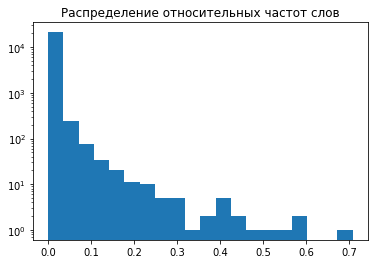

In [ ]:
plt.hist(word_doc_freq, bins=20)
plt.title('Распределение относительных частот слов')
plt.yscale('log');

In [ ]:
VECTORIZATION_MODE = 'tfidf'
train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)
test_vectors = vectorize_texts(test_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)

print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print('Размерность матрицы признаков тестовой выборки', test_vectors.shape)
print()
print('Количество ненулевых элементов в обучающей выборке', train_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])))
print()
print('Количество ненулевых элементов в тестовой выборке', test_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1])))

Размерность матрицы признаков обучающей выборки (11314, 21628)
Размерность матрицы признаков тестовой выборки (7532, 21628)

Количество ненулевых элементов в обучающей выборке 1126792
Процент заполненности матрицы признаков 0.46%

Количество ненулевых элементов в тестовой выборке 721529
Процент заполненности матрицы признаков 0.44%


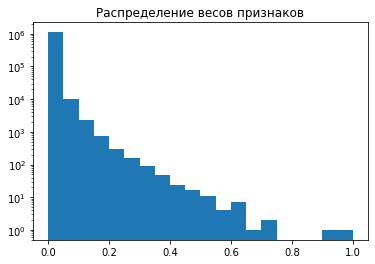

In [ ]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log');

### Распределение классов

In [ ]:
UNIQUE_LABELS_N = len(set(train_source['target']))
print('Количество уникальных меток', UNIQUE_LABELS_N)

Количество уникальных меток 20


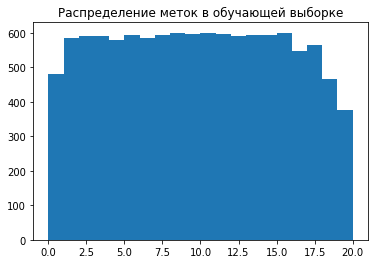

In [ ]:
plt.hist(train_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в обучающей выборке');

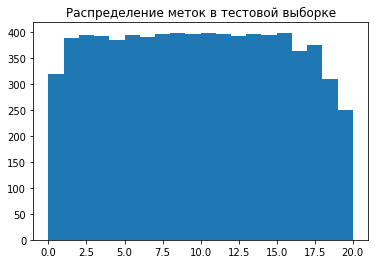

In [ ]:
plt.hist(test_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в тестовой выборке');

### PyTorch Dataset

In [ ]:
train_dataset = SparseFeaturesDataset(train_vectors, train_source['target'])
test_dataset = SparseFeaturesDataset(test_vectors, test_source['target'])

## Обучение модели на PyTorch

In [ ]:
model = nn.Linear(UNIQUE_WORDS_N, UNIQUE_LABELS_N)

scheduler = lambda optim: \
    torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, verbose=True)

best_val_loss, best_model = train_eval_loop(model=model,
                                            train_dataset=train_dataset,
                                            val_dataset=test_dataset,
                                            criterion=F.cross_entropy,
                                            lr=1e-1,
                                            epoch_n=200,
                                            batch_size=32,
                                            l2_reg_alpha=0,
                                            lr_scheduler_ctor=scheduler)

Эпоха 0
Эпоха: 354 итераций, 2.04 сек
Среднее значение функции потерь на обучении 2.2250226864033498
Среднее значение функции потерь на валидации 2.1193228081121283
Новая лучшая модель!

Эпоха 1
Эпоха: 354 итераций, 1.87 сек
Среднее значение функции потерь на обучении 0.9164793370133739
Среднее значение функции потерь на валидации 1.6757678445112907
Новая лучшая модель!

Эпоха 2
Эпоха: 354 итераций, 1.85 сек
Среднее значение функции потерь на обучении 0.4659293549040617
Среднее значение функции потерь на валидации 1.4736663820379872
Новая лучшая модель!

Эпоха 3
Эпоха: 354 итераций, 1.88 сек
Среднее значение функции потерь на обучении 0.2840370426406968
Среднее значение функции потерь на валидации 1.3451766247971584
Новая лучшая модель!

Эпоха 4
Эпоха: 354 итераций, 1.86 сек
Среднее значение функции потерь на обучении 0.19067820321537007
Среднее значение функции потерь на валидации 1.2647168775231152
Новая лучшая модель!

Эпоха 5
Эпоха: 354 итераций, 1.85 сек
Среднее значение функции п

## Оценка качества

In [ ]:
train_pred = predict_with_model(best_model, train_dataset)

train_loss = F.cross_entropy(torch.from_numpy(train_pred),
                             torch.from_numpy(train_source['target']).long())

print('Среднее значение функции потерь на обучении', float(train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], train_pred.argmax(-1)))
print()



test_pred = predict_with_model(best_model, test_dataset)

test_loss = F.cross_entropy(torch.from_numpy(test_pred),
                            torch.from_numpy(test_source['target']).long())

print('Среднее значение функции потерь на валидации', float(test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], test_pred.argmax(-1)))

100%|██████████| 354/353.5625 [00:01<00:00, 201.37it/s]
  9%|▉         | 21/235.375 [00:00<00:01, 207.58it/s]

Среднее значение функции потерь на обучении 0.003156959777697921
Доля верных ответов 0.9993812975075128



236it [00:01, 205.16it/s]                             

Среднее значение функции потерь на валидации 0.9307225942611694
Доля верных ответов 0.7651354221986192


# Альтернативная реализация на scikit-learn

In [ ]:
sklearn_pipeline = Pipeline((('vect', TfidfVectorizer(tokenizer=tokenize_text_simple_regex,
                                                      max_df=MAX_DF,
                                                      min_df=MIN_COUNT)),
                             ('cls', LogisticRegression())))
sklearn_pipeline.fit(train_source['data'], train_source['target']);

## Оценка качества

In [ ]:
sklearn_train_pred = sklearn_pipeline.predict_proba(train_source['data'])
sklearn_train_loss = F.cross_entropy(torch.from_numpy(sklearn_train_pred),
                                                 torch.from_numpy(train_source['target']))
print('Среднее значение функции потерь на обучении', float(sklearn_train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], sklearn_train_pred.argmax(-1)))
print()

sklearn_test_pred = sklearn_pipeline.predict_proba(test_source['data'])
sklearn_test_loss = F.cross_entropy(torch.from_numpy(sklearn_test_pred),
                                                torch.from_numpy(test_source['target']))
print('Среднее значение функции потерь на валидации', float(sklearn_test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], sklearn_test_pred.argmax(-1)))

Среднее значение функции потерь на обучении 2.495478891857855
Доля верных ответов 0.9716280714159449

Среднее значение функции потерь на валидации 2.653902258233705
Доля верных ответов 0.8190387679235263


### Моя модель

In [4]:
import nltk
nltk.download('wordnet')
lemma = nltk.wordnet.WordNetLemmatizer()

sno = nltk.stem.SnowballStemmer('english')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [95]:
TOKEN_RE = re.compile(r'[\w\d]+')


def tokenize_text_simple_regex(txt, min_token_size=4, ngram=1):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    if ngram <= 1:
        return [token for token in all_tokens if len(token) >= min_token_size]
    else:
        tokenized = [token for token in all_tokens if len(token) >= min_token_size]
        return [tuple(tokenized[i: i + ngram]) for i in range(0, len(tokenized), ngram)]

def tokenize_text_lemmatized(txt, min_token_size=4, ngram=1):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    lemmatized = [lemma.lemmatize(token) for token in all_tokens]
    if ngram <= 1:
        return list(filter(lambda x: len(x) >= min_token_size, lemmatized))
    else:
        lemmatized = list(filter(lambda x: len(x) >= min_token_size, lemmatized))
        return [tuple(lemmatized[i: i + ngram]) for i in range(0, len(lemmatized), ngram)]


def tokenize_text_stemmed(txt, min_token_size=4, ngram=1):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    stemmed = [sno.stem(token) for token in all_tokens]
    if ngram <= 1:
        return list(filter(lambda x: len(x) >= min_token_size, stemmed))
    else:
        stemmed = list(filter(lambda x: len(x) >= min_token_size, stemmed))
        return [tuple(stemmed[i: i + ngram]) for i in range(0, len(stemmed), ngram)]


# def character_tokenize(txt):
#     return list(txt)


# def tokenize_corpus(texts, tokenizer=tokenize_text_simple_regex, **tokenizer_kwargs):
#     return [tokenizer(text, **tokenizer_kwargs) for text in texts]


# def add_fake_token(word2id, token='<PAD>'):
#     word2id_new = {token: i + 1 for token, i in word2id.items()}
#     word2id_new[token] = 0
#     return word2id_new


# def texts_to_token_ids(tokenized_texts, word2id):
#     return [[word2id[token] for token in text if token in word2id]
#             for text in tokenized_texts]


def build_vocabulary(tokenized_texts, max_size=1000000, max_doc_freq=0.8, min_count=5, pad_word=None, use_pmi_filter=False, pmi_voc_prev=None, pmi_wl_matrix=None):
    word_counts = collections.defaultdict(int)
    doc_n = 0

    # посчитать количество документов, в которых употребляется каждое слово
    # а также общее количество документов
    for txt in tokenized_texts:
        doc_n += 1
        unique_text_tokens = set(txt)
        for token in unique_text_tokens:
            word_counts[token] += 1
    
    # убрать слишком редкие и слишком частые слова
    
    if use_pmi_filter and pmi_wl_matrix is not None and pmi_voc_prev is not None:
        # pmi_std_bad = (np.std(pmi_wl_matrix, axis=1) >= 1.5)
        pmi_median_bad = (np.median(pmi_wl_matrix, axis=1) >= 0.5)
        word_counts = {word: cnt for word, cnt in word_counts.items()
                       if cnt >= min_count and cnt / doc_n <= max_doc_freq 
                       and pmi_median_bad[pmi_voc_prev[word]]}
    else:
        word_counts = {word: cnt for word, cnt in word_counts.items()
                       if cnt >= min_count and cnt / doc_n <= max_doc_freq}

    # отсортировать слова по убыванию частоты
    sorted_word_counts = sorted(word_counts.items(),
                                reverse=True,
                                key=lambda pair: pair[1])

    # добавим несуществующее слово с индексом 0 для удобства пакетной обработки
    if pad_word is not None:
        sorted_word_counts = [(pad_word, 0)] + sorted_word_counts

    # если у нас по прежнему слишком много слов, оставить только max_size самых частотных
    if len(word_counts) > max_size:
        sorted_word_counts = sorted_word_counts[:max_size]

    # нумеруем слова
    word2id = {word: i for i, (word, _) in enumerate(sorted_word_counts)}

    # # нормируем частоты слов
    word2freq = np.array([cnt  for _, cnt in sorted_word_counts], dtype='float32')  # cnt / doc_n

    return word2id, word2freq


def vectorize_texts(tokenized_texts, word2id, word2freq, mode='tfidf', scale=None, pmi_wl_matrix=None, scalers=None):
    assert mode in {'tfidf', 'idf', 'tf', 'bin', 'ltfidf', 'pmi', 'tfidfnew', 'ltfidfnew'}
    assert scale in {'minmax', 'rownorm', 'std', None}
    n_docs = len(tokenized_texts)
    # считаем количество употреблений каждого слова в каждом документе
    result = scipy.sparse.dok_matrix((len(tokenized_texts), len(word2id)), dtype='float32')
    for text_i, text in enumerate(tokenized_texts):
        for token in text:
            if token in word2id:
                result[text_i, word2id[token]] += 1

    # получаем бинарные вектора "встречается или нет"
    if mode == 'bin':
        result = (result > 0).astype('float32')

    # получаем вектора относительных частот слова в документе
    elif mode == 'tf':
        result = result.tocsr()
        result = result.multiply(1 / result.sum(1))

    # полностью убираем информацию о количестве употреблений слова в данном документе,
    # но оставляем информацию о частотности слова в корпусе в целом
    elif mode == 'idf':
        result = (result > 0).astype('float32').multiply(n_docs / word2freq)

    # учитываем всю информацию, которая у нас есть:
    # частоту слова в документе и частоту слова в корпусе
    elif mode == 'tfidf':
        result = result.tocsr()
        result = result.multiply(1 / result.sum(1))  # разделить каждую строку на её длину
        result = result.multiply(n_docs / word2freq)  # разделить каждый столбец на вес слова
        
    elif mode == 'ltfidf':
        result = (result.multiply(1 / result.sum(1))).log1p()
        result = result.multiply(n_docs / word2freq)

    elif mode == 'tfidfnew':
        result = result.tocsr()
        idf = np.log((n_docs + 1)/ (word2freq + 1)) + 1
        result = result.multiply(1 / result.sum(1))  # разделить каждую строку на её длину
        result = result.multiply(idf)  # разделить каждый столбец на вес слова
        
    elif mode == 'ltfidfnew':
        idf = np.log((n_docs + 1)/ (word2freq + 1)) + 1
        result = (result.multiply(1 / result.sum(1))).log1p()
        result = result.multiply(idf)
  
    if scale == 'std':
        result = result.tocsc()
        if scalers is None:
            rstd = 1. / result.A.std(axis=0)
            result = result.multiply(rstd)
            return result.tocsr(), None, rstd
        else:
            result = result.multiply(scalers[1])
    elif scale == 'minmax':
        result = result.tocsc()
        if scalers is None:
            rmin = result.min()
            result -= rmin
            rmax = 1. / (result.max() + 1e-6)
            result = result.multiply(rmax)
            return result.tocsr(), rmin, rmax
        else:
          result -= scalers[0]
          result = result.multiply(scalers[1])
    elif scale == 'rownorm':
        result = result.tocsr()
        rown = np.expand_dims(1. / scipy.sparse.linalg.norm(result, axis=1), axis=1)
        result = result.multiply(rown)
        
    return result.tocsr()



def compute_pmi_wl_matrix(tokenized_texts, word2id, labels, naive=False):
    # train_source['data']
    nc = len(tokenized_texts)
    nl = len(set(labels))
    nlall = len(labels)
    nw = len(word2id)
    wl_matrix = np.zeros((nw, nl))
    pmi_wl_matrix = np.zeros((nw, nl))
    for text_i, text in enumerate(tokenized_texts):
        for token in text:
            if token in word2id:
                wl_matrix[word2id[token]][labels[text_i]] = 1.
    # p(w,l) = n_docs_with_w_and_l / n_docs
    # p(w) = n_docs_with_w / n_docs
    # p(l) = n_docs_with_l / n_docs
    # p(w, l) / p(w) / p(l) = n_docs_with_w_and_l * n_docs / n_docs_with_w / n_docs_with_l
    if naive:
        pw = np.zeros(nw)
        for i in range(nw):
            for j in range(nl):
                pw[i] += wl_matrix[i][j]
        pl = np.zeros(nl)
        for i in range(nlall):
            pl[labels[i]] += 1.
        for i in range(nw):
            for j in range(nl):
                pmi_wl_matrix[i][j] = np.log1p(wl_matrix[i][j] * nlall/pw[i]/pl[j])
        return pmi_wl_matrix
    return None
       
    

# PAD_TOKEN = '__PAD__'
# NUMERIC_TOKEN = '__NUMBER__'
# NUMERIC_RE = re.compile(r'^([0-9.,e+\-]+|[mcxvi]+)$', re.I)


# def replace_number_nokens(tokenized_texts):
#     return [[token if not NUMERIC_RE.match(token) else NUMERIC_TOKEN for token in text]
#             for text in tokenized_texts]

In [ ]:
print(np.shape(np.expand_dims(np.array([1, 2, 3]), axis=1)))
print(np.sum(np.ones((10, 5)), axis=0))

(3, 1)
[10. 10. 10. 10. 10.]


In [96]:
train_tokenized = tokenize_corpus(train_source['data'], tokenizer=tokenize_text_simple_regex, min_token_size=4)
test_tokenized = tokenize_corpus(test_source['data'], tokenizer=tokenize_text_simple_regex, min_token_size=4)
print(' '.join(train_tokenized[0]))

from lerxst where thing subject what this nntp posting host rac3 organization university maryland college park lines wondering anyone there could enlighten this other door sports looked from late early called bricklin doors were really small addition front bumper separate from rest body this know anyone tellme model name engine specs years production where this made history whatever info have this funky looking please mail thanks brought your neighborhood lerxst


In [97]:
MAX_DF = 0.8
MIN_COUNT = 5
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
UNIQUE_WORDS_N = len(vocabulary)
print('Количество уникальных токенов', UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10])


Количество уникальных токенов 21628
[('that', 0), ('this', 1), ('have', 2), ('with', 3), ('writes', 4), ('article', 5), ('posting', 6), ('host', 7), ('nntp', 8), ('there', 9)]


In [8]:
UNIQUE_LABELS_N = len(set(train_source['target']))
print('Количество уникальных меток', UNIQUE_LABELS_N)

Количество уникальных меток 20


In [ ]:
pmi_wl_matrix_naive = compute_pmi_wl_matrix(train_tokenized, vocabulary, train_source['target'], naive=True)

In [ ]:
# print(pmi_wl_matrix[0, :])
print(pmi_wl_matrix_naive[0, :])

[0.77865569 0.67735533 0.67151038 0.67233896 0.68245003 0.66985957
 0.67651388 0.66903731 0.66576911 0.66658305 0.66414739 0.66821714
 0.67151038 0.66903731 0.66985957 0.66495722 0.71102668 0.69465314
 0.79595606 0.91650291]


[0.77865569 0.67735533 0.67151038 0.67233896 0.68245003 0.66985957
 0.67651388 0.66903731 0.66576911 0.66658305 0.66414739 0.66821714
 0.67151038 0.66903731 0.66985957 0.66495722 0.71102668 0.69465314
 0.79595606 0.91650291]
[0.77865569 0.67735533 0.67151038 0.67233896 0.68245003 0.66985957
 0.67651388 0.66903731 0.66576911 0.66658305 0.66414739 0.66821714
 0.67151038 0.66903731 0.66985957 0.66495722 0.71102668 0.69465314
 0.79595606 0.91650291]
[0.         0.         0.         0.         1.77386678 0.
 1.76388159 0.         0.         0.         0.         0.
 1.7554336  0.         0.         0.         1.82138347 0.
 0.         0.        ]


(array([1030.,  400.,  460.,  598.,  775., 1062., 1490., 4685., 8489.,
        2639.]),
 array([0.06149309, 0.13623318, 0.21097328, 0.28571337, 0.36045346,
        0.43519355, 0.50993364, 0.58467373, 0.65941382, 0.73415391,
        0.80889401]),
 <a list of 10 Patch objects>)

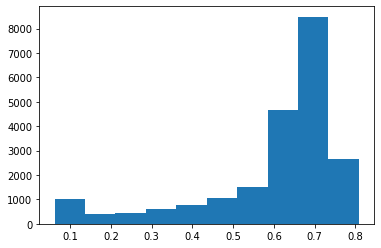

In [ ]:
print(pmi_wl_matrix_naive[0, :])
print(pmi_wl_matrix_naive[1, :])
print(pmi_wl_matrix_naive[18000, :])
plt.hist(np.std(pmi_wl_matrix_naive, axis=1))
# plt.hist(pmi_wl_matrix_naive)


Фильтруем словарь второй раз с PMI

In [ ]:
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT, use_pmi_filter=True, pmi_voc_prev=vocabulary, pmi_wl_matrix=pmi_wl_matrix_naive)
UNIQUE_WORDS_N = len(vocabulary)
print('Количество уникальных токенов', UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10])


NameError: ignored

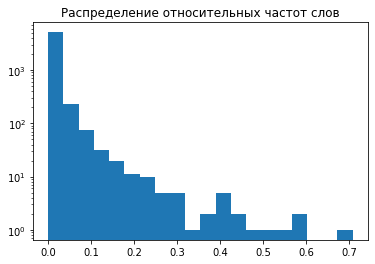

In [ ]:
plt.hist(word_doc_freq, bins=20)
plt.title('Распределение относительных частот слов')
plt.yscale('log');

In [98]:
VECTORIZATION_MODE = 'tfidfnew'

train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE, scale=None)
test_vectors = vectorize_texts(test_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE, scale=None)

print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print('Размерность матрицы признаков тестовой выборки', test_vectors.shape)
print()
print('Количество ненулевых элементов в обучающей выборке', train_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])))
print()
print('Количество ненулевых элементов в тестовой выборке', test_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1])))

Размерность матрицы признаков обучающей выборки (11314, 21628)
Размерность матрицы признаков тестовой выборки (7532, 21628)

Количество ненулевых элементов в обучающей выборке 1126792
Процент заполненности матрицы признаков 0.46%

Количество ненулевых элементов в тестовой выборке 721529
Процент заполненности матрицы признаков 0.44%


In [29]:
vectorizer = TfidfVectorizer(tokenizer=tokenize_text_simple_regex,
                             max_df=MAX_DF,
                             min_df=MIN_COUNT,
                             sublinear_tf=False)
train_vectors_sklearn = vectorizer.fit_transform(train_source['data'])
test_vectors_sklearn = vectorizer.transform(test_source['data'])

print('Размерность матрицы признаков обучающей выборки', train_vectors_sklearn.shape)
print('Размерность матрицы признаков тестовой выборки', test_vectors_sklearn.shape)
print()
print('Количество ненулевых элементов в обучающей выборке', train_vectors_sklearn.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(train_vectors_sklearn.nnz * 100 / (train_vectors_sklearn.shape[0] * train_vectors_sklearn.shape[1])))
print()
print('Количество ненулевых элементов в тестовой выборке', test_vectors_sklearn.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(test_vectors_sklearn.nnz * 100 / (test_vectors_sklearn.shape[0] * test_vectors_sklearn.shape[1])))

Размерность матрицы признаков обучающей выборки (11314, 21628)
Размерность матрицы признаков тестовой выборки (7532, 21628)

Количество ненулевых элементов в обучающей выборке 1126792
Процент заполненности матрицы признаков 0.46%

Количество ненулевых элементов в тестовой выборке 721529
Процент заполненности матрицы признаков 0.44%


In [106]:
train_vectors_new = deepcopy(train_vectors)

In [37]:
vectorizer = TfidfVectorizer(tokenizer=tokenize_text_simple_regex,
                             max_df=MAX_DF,
                             min_df=MIN_COUNT,
                             sublinear_tf=False)
train_vectors_nice = vectorizer.fit_transform(train_source['data'])
test_vectors_nice = vectorizer.transform(test_source['data'])

In [102]:
sc = MaxAbsScaler()
train_vectors_new = sc.fit_transform(train_vectors_new)

In [79]:
sc = StandardScaler(with_mean=False)
train_vectors_new = sc.fit_transform(train_vectors_new)

In [107]:
sc = Normalizer()
train_vectors_new = sc.fit_transform(train_vectors_new)

In [100]:
print(max(train_vectors_nice.A[train_vectors_nice[0].nonzero()]))
print(max(train_vectors_new.A[train_vectors_new[0].nonzero()]))

0.25651549389185374
0.13979957


(array([ 7.,  7.,  5.,  7., 10.,  8.,  4.,  3.,  1.,  2.]),
 array([0.04541198, 0.06584768, 0.08628338, 0.10671908, 0.12715478,
        0.14759049, 0.16802618, 0.18846188, 0.20889759, 0.22933328,
        0.24976899], dtype=float32),
 <a list of 10 Patch objects>)

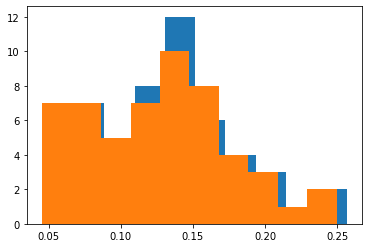

In [108]:
plt.hist(train_vectors_nice.A[train_vectors_nice[0].nonzero()])
plt.hist(train_vectors_new.A[train_vectors_new[0].nonzero()])

Отредактированное dlnlputils/pipeline.py

In [ ]:
import copy
import datetime
import random
import traceback

import numpy as np
import torch
from torch.utils.data import DataLoader


def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True


def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError('Недопустимый тип данных {}'.format(type(data)))


def print_grad_stats(model):
    mean = 0
    std = 0
    norm = 1e-5
    for param in model.parameters():
        grad = getattr(param, 'grad', None)
        if grad is not None:
            mean += grad.data.abs().mean()
            std += grad.data.std()
            norm += 1
    mean /= norm
    std /= norm
    print(f'Mean grad {mean}, std {std}, n {norm}')




In [ ]:
def train_eval_loop(model, train_dataset, val_dataset, criterion,
                    lr=1e-4, epoch_n=10, batch_size=32,
                    device=None, early_stopping_patience=10, l2_reg_alpha=0,
                    max_batches_per_epoch_train=10000,
                    max_batches_per_epoch_val=1000,
                    data_loader_ctor=DataLoader,
                    optimizer_ctor=None,
                    lr_scheduler_ctor=None,
                    shuffle_train=True,
                    dataloader_workers_n=0):
    """
    Цикл для обучения модели. После каждой эпохи качество модели оценивается по отложенной выборке.
    :param model: torch.nn.Module - обучаемая модель
    :param train_dataset: torch.utils.data.Dataset - данные для обучения
    :param val_dataset: torch.utils.data.Dataset - данные для оценки качества
    :param criterion: функция потерь для настройки модели
    :param lr: скорость обучения
    :param epoch_n: максимальное количество эпох
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param early_stopping_patience: наибольшее количество эпох, в течение которых допускается
        отсутствие улучшения модели, чтобы обучение продолжалось.
    :param l2_reg_alpha: коэффициент L2-регуляризации
    :param max_batches_per_epoch_train: максимальное количество итераций на одну эпоху обучения
    :param max_batches_per_epoch_val: максимальное количество итераций на одну эпоху валидации
    :param data_loader_ctor: функция для создания объекта, преобразующего датасет в батчи
        (по умолчанию torch.utils.data.DataLoader)
    :return: кортеж из двух элементов:
        - среднее значение функции потерь на валидации на лучшей эпохе
        - лучшая модель
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device)
    model.to(device)

    if optimizer_ctor is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg_alpha)
    else:
        optimizer = optimizer_ctor(model.parameters(), lr=lr)

    if lr_scheduler_ctor is not None:
        lr_scheduler = lr_scheduler_ctor(optimizer)
    else:
        lr_scheduler = None

    train_dataloader = data_loader_ctor(train_dataset, batch_size=batch_size, shuffle=shuffle_train,
                                        num_workers=dataloader_workers_n)
    val_dataloader = data_loader_ctor(val_dataset, batch_size=batch_size, shuffle=False,
                                      num_workers=dataloader_workers_n)

    best_val_loss = float('inf')
    best_epoch_i = 0
    best_model = copy.deepcopy(model)

    for epoch_i in range(epoch_n):
        try:
            epoch_start = datetime.datetime.now()
            print('Эпоха {}'.format(epoch_i))

            model.train()
            mean_train_loss = 0
            train_batches_n = 0
            for batch_i, (batch_x, batch_y) in enumerate(train_dataloader):
                if batch_i > max_batches_per_epoch_train:
                    break

                batch_x = copy_data_to_device(batch_x, device)
                batch_y = copy_data_to_device(batch_y, device)

                pred = model(batch_x)
                loss = criterion(pred, batch_y)

                model.zero_grad()
                loss.backward()

                optimizer.step()

                mean_train_loss += float(loss)
                train_batches_n += 1

            mean_train_loss /= train_batches_n
            print('Эпоха: {} итераций, {:0.2f} сек'.format(train_batches_n,
                                                           (datetime.datetime.now() - epoch_start).total_seconds()))
            print('Среднее значение функции потерь на обучении', mean_train_loss)



            model.eval()
            mean_val_loss = 0
            val_batches_n = 0

            with torch.no_grad():
                for batch_i, (batch_x, batch_y) in enumerate(val_dataloader):
                    if batch_i > max_batches_per_epoch_val:
                        break

                    batch_x = copy_data_to_device(batch_x, device)
                    batch_y = copy_data_to_device(batch_y, device)

                    pred = model(batch_x)
                    loss = criterion(pred, batch_y)

                    mean_val_loss += float(loss)
                    val_batches_n += 1

            mean_val_loss /= val_batches_n
            print('Среднее значение функции потерь на валидации', mean_val_loss)

            if mean_val_loss < best_val_loss:
                best_epoch_i = epoch_i
                best_val_loss = mean_val_loss
                best_model = copy.deepcopy(model)
                print('Новая лучшая модель!')
            elif epoch_i - best_epoch_i > early_stopping_patience:
                print('Модель не улучшилась за последние {} эпох, прекращаем обучение'.format(
                    early_stopping_patience))
                break

            if lr_scheduler is not None:
                lr_scheduler.step(mean_val_loss)

            print()
        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем')
            break
        except Exception as ex:
            print('Ошибка при обучении: {}\n{}'.format(ex, traceback.format_exc()))
            break

    return best_val_loss, best_model


def predict_with_model(model, dataset, device=None, batch_size=32, num_workers=0, return_labels=False):
    """
    :param model: torch.nn.Module - обученная модель
    :param dataset: torch.utils.data.Dataset - данные для применения модели
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :return: numpy.array размерности len(dataset) x *
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    results_by_batch = []

    device = torch.device(device)
    model.to(device)
    model.eval()

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    labels = []
    with torch.no_grad():
        import tqdm
        for batch_x, batch_y in tqdm.tqdm(dataloader, total=len(dataset)/batch_size):
            batch_x = copy_data_to_device(batch_x, device)

            if return_labels:
                labels.append(batch_y.numpy())

            batch_pred = model(batch_x)
            results_by_batch.append(batch_pred.detach().cpu().numpy())

    if return_labels:
        return np.concatenate(results_by_batch, 0), np.concatenate(labels, 0)
    else:
        return np.concatenate(results_by_batch, 0)

In [109]:
train_dataset = SparseFeaturesDataset(train_vectors, train_source['target'])
test_dataset = SparseFeaturesDataset(test_vectors, test_source['target'])

In [114]:
model = nn.Linear(UNIQUE_WORDS_N, UNIQUE_LABELS_N)

scheduler = lambda optim: \
    torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, verbose=True)

best_val_loss, best_model = train_eval_loop(model=model,
                                            train_dataset=train_dataset,
                                            val_dataset=test_dataset,
                                            criterion=F.cross_entropy,
                                            lr=1e-1,
                                            epoch_n=200,
                                            batch_size=32,
                                            l2_reg_alpha=0.000001, # regularization with weight_decay
                                            lr_scheduler_ctor=scheduler)

Эпоха 0
Эпоха: 354 итераций, 4.18 сек
Среднее значение функции потерь на обучении 0.7530746851011184
Среднее значение функции потерь на валидации 0.7262613283375562
Новая лучшая модель!

Эпоха 1
Эпоха: 354 итераций, 4.24 сек
Среднее значение функции потерь на обучении 0.10728997076824728
Среднее значение функции потерь на валидации 0.7323530820214142

Эпоха 2
Эпоха: 354 итераций, 4.25 сек
Среднее значение функции потерь на обучении 0.08409015635965066
Среднее значение функции потерь на валидации 0.7111776174377586
Новая лучшая модель!

Эпоха 3
Эпоха: 354 итераций, 4.23 сек
Среднее значение функции потерь на обучении 0.07544981910831343
Среднее значение функции потерь на валидации 0.7017581203984002
Новая лучшая модель!

Эпоха 4
Эпоха: 354 итераций, 4.11 сек
Среднее значение функции потерь на обучении 0.07224808589655296
Среднее значение функции потерь на валидации 0.7101388792112723

Эпоха 5
Эпоха: 354 итераций, 4.16 сек
Среднее значение функции потерь на обучении 0.07327529139248497
С

In [115]:
train_pred = predict_with_model(best_model, train_dataset)

train_loss = F.cross_entropy(torch.from_numpy(train_pred),
                             torch.from_numpy(train_source['target']).long())

print('Среднее значение функции потерь на обучении', float(train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], train_pred.argmax(-1)))
print()



test_pred = predict_with_model(best_model, test_dataset)

test_loss = F.cross_entropy(torch.from_numpy(test_pred),
                            torch.from_numpy(test_source['target']).long())

print('Среднее значение функции потерь на валидации', float(test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], test_pred.argmax(-1)))

100%|██████████| 354/353.5625 [00:02<00:00, 155.88it/s]
  6%|▋         | 15/235.375 [00:00<00:01, 141.86it/s]

Среднее значение функции потерь на обучении 0.03253213316202164
Доля верных ответов 0.9992929114371575



236it [00:01, 157.98it/s]                             

Среднее значение функции потерь на валидации 0.6841444373130798
Доля верных ответов 0.8262081784386617


Sklearn

In [ ]:
sklearn_pipeline = Pipeline((('vect', TfidfVectorizer(tokenizer=tokenize_text_simple_regex,
                                                      # tokenizer=tokenize_text_stemmed,
                                                      max_df=MAX_DF,
                                                      min_df=MIN_COUNT,
                                                      sublinear_tf=True)),
                             ('cls', LogisticRegression())))
sklearn_pipeline.fit(train_source['data'], train_source['target'])

sklearn_train_pred = sklearn_pipeline.predict_proba(train_source['data'])
sklearn_train_loss = F.cross_entropy(torch.from_numpy(sklearn_train_pred),
                                                 torch.from_numpy(train_source['target']))
print('Среднее значение функции потерь на обучении', float(sklearn_train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], sklearn_train_pred.argmax(-1)))
print()

sklearn_test_pred = sklearn_pipeline.predict_proba(test_source['data'])
sklearn_test_loss = F.cross_entropy(torch.from_numpy(sklearn_test_pred),
                                                torch.from_numpy(test_source['target']))
print('Среднее значение функции потерь на валидации', float(sklearn_test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], sklearn_test_pred.argmax(-1)))

NameError: ignored

In [ ]:
# vectorizer = TfidfVectorizer(tokenizer=tokenize_text_lemmatized,
#                              max_df=MAX_DF,
#                              min_df=MIN_COUNT,
#                              sublinear_tf=True)
# train_vectors = vectorizer.fit_transform(train_source['data'])
# test_vectors = vectorizer.transform(test_source['data'])

cls = LogisticRegression(penalty='l2', C=70, solver='liblinear')
cls.fit(train_vectors, train_source['target'])

sklearn_train_pred = cls.predict_proba(train_vectors)
sklearn_train_loss = F.cross_entropy(torch.from_numpy(sklearn_train_pred),
                                                 torch.from_numpy(train_source['target']))
print('Среднее значение функции потерь на обучении', float(sklearn_train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], sklearn_train_pred.argmax(-1)))
print()

sklearn_test_pred = cls.predict_proba(test_vectors)
sklearn_test_loss = F.cross_entropy(torch.from_numpy(sklearn_test_pred),
                                                torch.from_numpy(test_source['target']))
print('Среднее значение функции потерь на валидации', float(sklearn_test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], sklearn_test_pred.argmax(-1)))

Среднее значение функции потерь на обучении 2.1285047504040344
Доля верных ответов 0.9994696835778681

Среднее значение функции потерь на валидации 2.4584708845757186
Доля верных ответов 0.7113648433351035


### Report

Сначала добавила регуляризацию (через weight_decay, просто передав 0.01, 0.001, ... коэффициенты в дефолтную функцию) -- модель вообще почти перестала обучаться. Я не поняла, что это было, т.к. регуляризация с C = 10, 100, 1000 в sklearn.LogisticRegression на тех же фичах улучшала предсказания.

Использование для обучения признаков, подготовленных с помощью TfidfVectorizer, сильно улучшило результаты. С признаками из TfidfVectorizer и на pytorch модели, и в обычной LogisticRegression при правильно подобранных коэффициентах регуляризации получаются результаты лучше, чем в Pipeline с той же LogisticRegression из курса, где коэффициенты не подбираются. Сначала я подумала, что это из-за других шкалирования/нормализациии данных, но дело оказалось в формуле для IDF.

Сделала лемматизацию и стемминг -- качество предсказаний ухудшилось. Словарь ожидаемо уменьшился. Я ожидала, что переобучение уменьшится, но как-то не очень.

Потом пошла по порядку.

1) Заменила tfidf на ltfidf (sublinear_tf=True в sklearn). В pytorch модели это ожидаемо не помогло, т.к. она переобучается, в sklearn улучшило на 2% результаты на валидации).
Изменение MAX_DF и MIN_COUNT не очень сильно улучшают все.

2) PMI мне вообще не понравилось использовать. Во-первых, в курсе очень странно дано определение PMI. По-моему, оно не совсем правильное. Если использовать максимально приближенное к нему определение PMI для расчета, то получается, что из-за того, что частотность слов не учитывается, фильтрация получается не очень качественной. Можно учитывать частотность слов, но я не пробовала.

3) Разные нормировки в применении к изначальным взвешенным через TF-IDF данным. 
Нормировка на std трейна каждой фичи не помогла. mean, чтобы сохранить разреженность, не вычитала. 
Нормировка каждого ряда на его норму не помогла.

4) Изменение формулы для IDF.
В курсе дана формула IDF = n_docs / word_frequencies, но в TfidfVectorizer и в других местах используется log(n_docs / word_frequencies) + 1, или же log((n_docs + 1) / (word_frequencies + 1)) + 1 для стабильности. С этой формулой + нормализацией + 0.000001 регуляризацией я получила такие же результаты, как с использованием TfidfVectorizer.